In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

# Add parent directory to path to import from ETL
sys.path.insert(0, str(Path().resolve().parent / '1. ETL'))

# Import column definitions from transformation script
from importlib.util import spec_from_file_location, module_from_spec
transformation_path = Path().resolve().parent / '1. ETL' / '03_transformation.py'
spec = spec_from_file_location("transformation", transformation_path)
transformation = module_from_spec(spec)
spec.loader.exec_module(transformation)

# Import column definitions
TARGETS = transformation.TARGETS
INPUTS = transformation.INPUTS
CATEGORICAL_INPUTS = transformation.CATEGORICAL_INPUTS
CONTINUOUS_INPUTS = transformation.CONTINUOUS_INPUTS

print("✓ Imported column definitions from 1. ETL/03_transformation.py")
print(f"  - {len(INPUTS)} input features")
print(f"  - {len(TARGETS)} target variables")
print(f"  - {len(CATEGORICAL_INPUTS)} categorical inputs")
print(f"  - {len(CONTINUOUS_INPUTS)} continuous inputs")

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 12
pd.set_option('display.max_columns', None)

## Load Database

In [ ]:
# Connect to database and load full dataset
conn = sqlite3.connect('../databases/nhanes_1st.db')
df = pd.read_sql_query('SELECT * FROM raw_dataset', conn)
conn.close()
print(f"Dataset shape: {df.shape}")

Dataset shape: (56893, 29)


## Univariate Analysis

**Purpose:** Analyze each variable individually to understand distributions, patterns, and characteristics.

**Steps:**
1. Identify variable types (categorical vs numerical)
2. Analyze target variables
3. Analyze continuous features
4. Analyze categorical features

In [ ]:
# Identify variable types: Categorical vs Numerical
print("="*80)
print("VARIABLE TYPE IDENTIFICATION")
print("="*80)

# Define target variables (excluded from feature analysis)
target_columns = [
    'has_cardiovascular_disease',
    'high_waist_circumference', 'high_triglycerides_mg_dl', 'low_hdl_mg_dl', 
    'high_blood_pressure', 'high_glucose_mg_dl',
    'kidney_acr_mg_g', 'liver_alt_U_L'
]

# Get feature columns (exclude targets)
feature_columns = [col for col in df.columns if col not in target_columns]

# Identify numerical vs categorical using pandas
numeric_features = df[feature_columns].select_dtypes(include=[np.number])
numerical_cols = [col for col in numeric_features.columns if df[col].nunique() > 10]
categorical_cols = [col for col in feature_columns if col not in numerical_cols]

# Summary
print(f"\nTotal Features: {len(feature_columns)}")
print(f"  - Numerical (Continuous): {len(numerical_cols)}")
print(f"  - Categorical: {len(categorical_cols)}")
print(f"  - Target Variables: {len(target_columns)}")

print(f"\n📊 Numerical Variables ({len(numerical_cols)}):")
for col in sorted(numerical_cols):
    print(f"  • {col}")

print(f"\n📋 Categorical Variables ({len(categorical_cols)}):")
for col in sorted(categorical_cols):
    print(f"  • {col} ({df[col].nunique()} unique values)")

print(f"\n🎯 Target Variables ({len(target_columns)}):")
for col in sorted(target_columns):
    print(f"  • {col}")


VARIABLE TYPE IDENTIFICATION

Total Features: 21
  - Numerical (Continuous): 18
  - Categorical: 3
  - Target Variables: 8

📊 Numerical Variables (18):
  • age
  • alcohol_drinks_per_week
  • bilirubin_mg_dl
  • body_mass_index
  • cholesterol_mg_dl
  • creatinine_mg_dl
  • heart_rate_bpm
  • height_cm
  • hemoglobin_g_dl
  • income_ratio
  • liver_ast_U_L
  • liver_ggt_U_L
  • mean_corpuscular_volume_fL
  • platelets_count
  • potassium_mmol_L
  • sodium_mmol_L
  • uric_acid_mg_dl
  • white_blood_cells_count

📋 Categorical Variables (3):
  • ethnicity (6 unique values)
  • gender (2 unique values)
  • smoking_status (3 unique values)

🎯 Target Variables (8):
  • has_cardiovascular_disease
  • high_blood_pressure
  • high_glucose_mg_dl
  • high_triglycerides_mg_dl
  • high_waist_circumference
  • kidney_acr_mg_g
  • liver_alt_U_L
  • low_hdl_mg_dl


1.1 TARGET: Cardiovascular Disease

Cardiovascular Disease:
  Healthy (0): 30,018 (52.76%)
  Has CVD (1): 4,079 (7.17%)
  Missing: 22,796 (40.07%)


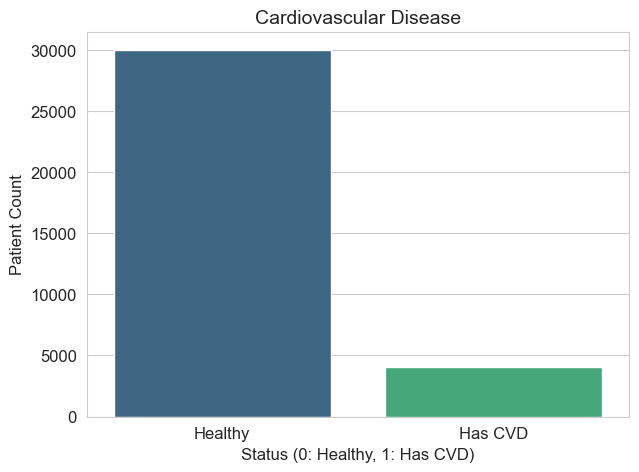


1.2 TARGET: Metabolic Syndrome Components (5 Labels)

High Waist Circumference:
  Normal (0): 26,397 (46.40%)
  Abnormal (1): 18,942 (33.29%)
  Missing: 11,554 (20.31%)


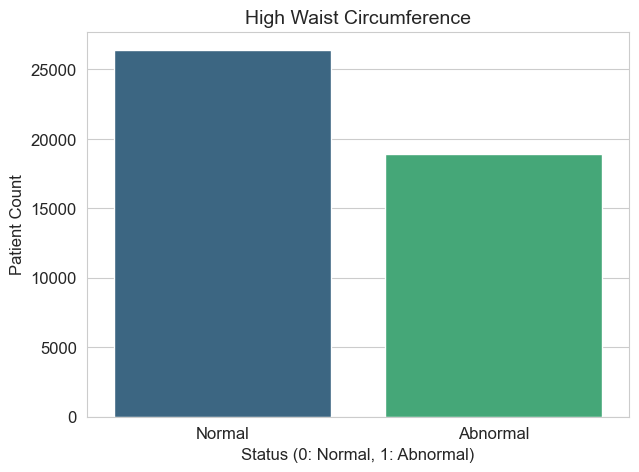


High Triglycerides Mg Dl:
  Normal (0): 13,725 (24.12%)
  Abnormal (1): 3,145 (5.53%)
  Missing: 40,023 (70.35%)


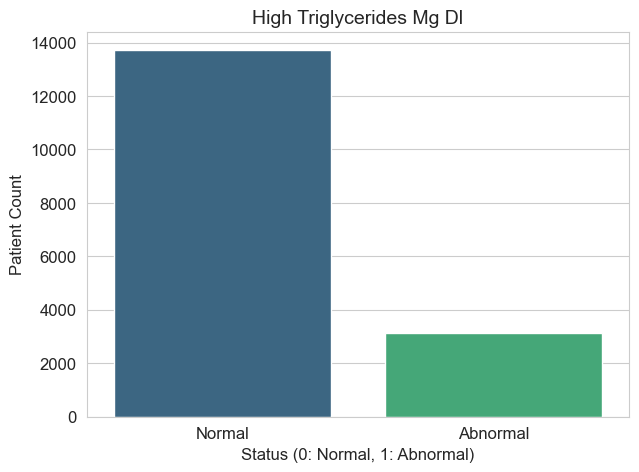


Low Hdl Mg Dl:
  Normal (0): 28,186 (49.54%)
  Abnormal (1): 11,150 (19.60%)
  Missing: 17,557 (30.86%)


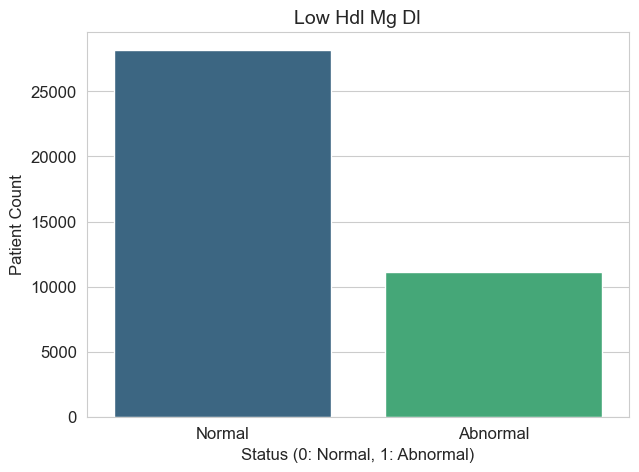


High Blood Pressure:
  Normal (0): 28,384 (49.89%)
  Abnormal (1): 10,520 (18.49%)
  Missing: 17,989 (31.62%)


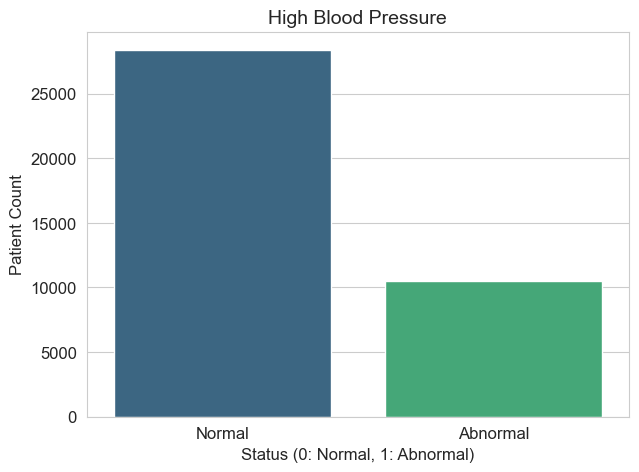


High Glucose Mg Dl:
  Normal (0): 7,491 (13.17%)
  Abnormal (1): 8,864 (15.58%)
  Missing: 40,538 (71.25%)


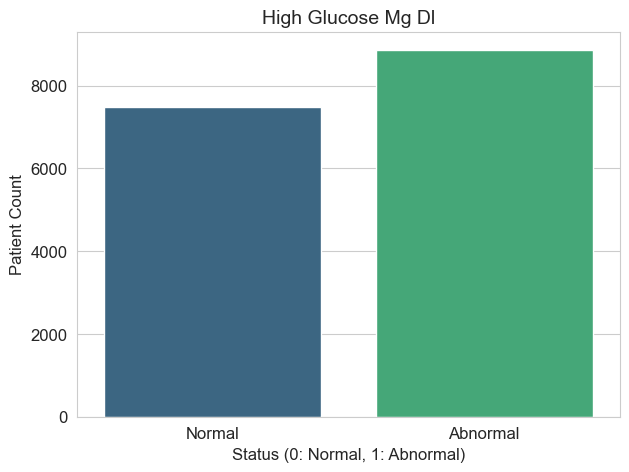


1.3 TARGET: Kidney Function (ACR Log)

Kidney Function (ACR Log):
  Mean: 2.4754
  Median: 2.2146
  Std: 1.0395
  Min: 0.0785
  Max: 9.9595
  Missing: 12,267 (21.56%)


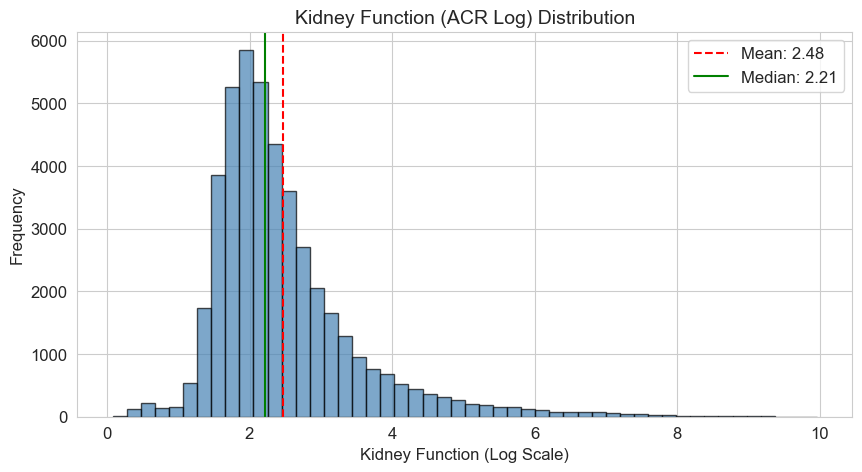


1.4 TARGET: Liver Function (ALT Log)

Liver Function (ALT Log):
  Mean: 2.9470
  Median: 2.8904
  Std: 0.5226
  Min: 0.6931
  Max: 6.5250
  Missing: 22,390 (39.35%)


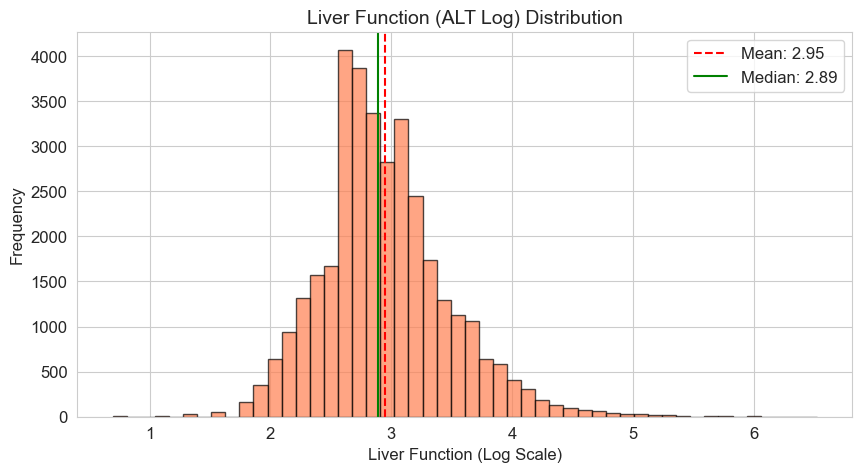

In [ ]:
# =========================================================
# 1. TARGET VARIABLE ANALYSIS
# =========================================================

# Helper function for binary classification targets
def analyze_binary_target(col_name, title, labels=('Normal', 'Abnormal')):
    """Analyze and visualize a binary target variable."""
    if col_name not in df.columns:
        return
    
    counts = df[col_name].value_counts(dropna=False)
    pct = df[col_name].value_counts(normalize=True, dropna=False) * 100
    missing = df[col_name].isnull().sum()
    
    print(f"\n{title}:")
    print(f"  {labels[0]} (0): {counts.get(0, 0):,} ({pct.get(0, 0):.2f}%)")
    print(f"  {labels[1]} (1): {counts.get(1, 0):,} ({pct.get(1, 0):.2f}%)")
    print(f"  Missing: {missing:,} ({missing/len(df)*100:.2f}%)")
    
    plt.figure(figsize=(7, 5))
    sns.countplot(x=col_name, data=df, hue=col_name, palette='viridis', legend=False)
    plt.title(title, fontsize=14)
    plt.xlabel(f'Status (0: {labels[0]}, 1: {labels[1]})')
    plt.ylabel('Patient Count')
    plt.xticks([0, 1], labels, rotation=0)
    plt.show()

# Helper function for regression targets
def analyze_regression_target(col_name, title, color='steelblue'):
    """Analyze and visualize a regression target variable."""
    if col_name not in df.columns:
        return
    
    data = df[col_name].dropna()
    missing = df[col_name].isnull().sum()
    
    print(f"\n{title}:")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Median: {data.median():.4f}")
    print(f"  Std: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Missing: {missing:,} ({missing/len(df)*100:.2f}%)")
    
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=50, color=color, alpha=0.7, edgecolor='black')
    plt.axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
    plt.axvline(data.median(), color='green', linestyle='-', label=f'Median: {data.median():.2f}')
    plt.title(f'{title} Distribution', fontsize=14)
    plt.xlabel(title.split('(')[0].strip() + ' (Log Scale)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 1.1 Cardiovascular Disease
print("="*80)
print("1.1 TARGET: Cardiovascular Disease")
print("="*80)
analyze_binary_target('has_cardiovascular_disease', 'Cardiovascular Disease', ('Healthy', 'Has CVD'))

# 1.2 Metabolic Syndrome Components
print("\n" + "="*80)
print("1.2 TARGET: Metabolic Syndrome Components (5 Labels)")
print("="*80)
metabolic_labels = [
    'high_waist_circumference',
    'high_triglycerides_mg_dl',
    'low_hdl_mg_dl',
    'high_blood_pressure',
    'high_glucose_mg_dl'
]

for label in metabolic_labels:
    analyze_binary_target(label, label.replace('_', ' ').title())

# 1.3 Kidney Function
print("\n" + "="*80)
print("1.3 TARGET: Kidney Function (ACR Log)")
print("="*80)
analyze_regression_target('kidney_acr_mg_g', 'Kidney Function (ACR Log)', 'steelblue')

# 1.4 Liver Function
print("\n" + "="*80)
print("1.4 TARGET: Liver Function (ALT Log)")
print("="*80)
analyze_regression_target('liver_alt_U_L', 'Liver Function (ALT Log)', 'coral')

2. NUMERICAL FEATURES: Descriptive Statistics

Analyzing 18 numerical variables:


,count,mean,std,min,25%,50%,75%,max
age,56893.0,34.071485,25.270227,5.397605e-79,11.00,31.000000,57.000000,80.00
income_ratio,49583.0,2.407602,1.633919,5.397605e-79,1.02,1.980000,3.870000,5.00
body_mass_index,47424.0,26.443765,8.188407,1.110000e+01,20.40,25.600000,31.100000,92.30
height_cm,47508.0,156.699590,22.321240,7.830000e+01,151.30,162.100000,171.200000,202.70
heart_rate_bpm,37178.0,73.118605,12.344447,3.400000e+01,64.00,72.000000,80.666667,180.00
white_blood_cells_count,43938.0,7.290216,3.529356,1.400000e+00,5.70,7.000000,8.500000,400.00
platelets_count,43938.0,258.994287,70.151729,8.000000e+00,211.00,251.000000,298.000000,1021.00
hemoglobin_g_dl,43938.0,13.693971,1.500680,5.400000e+00,12.70,13.600000,14.700000,19.90
mean_corpuscular_volume_fL,43938.0,86.794736,6.480780,3.540000e+01,83.10,87.300000,91.000000,116.70
creatinine_mg_dl,34512.0,0.871477,0.449245,2.500000e-01,0.68,0.820000,0.980000,17.41


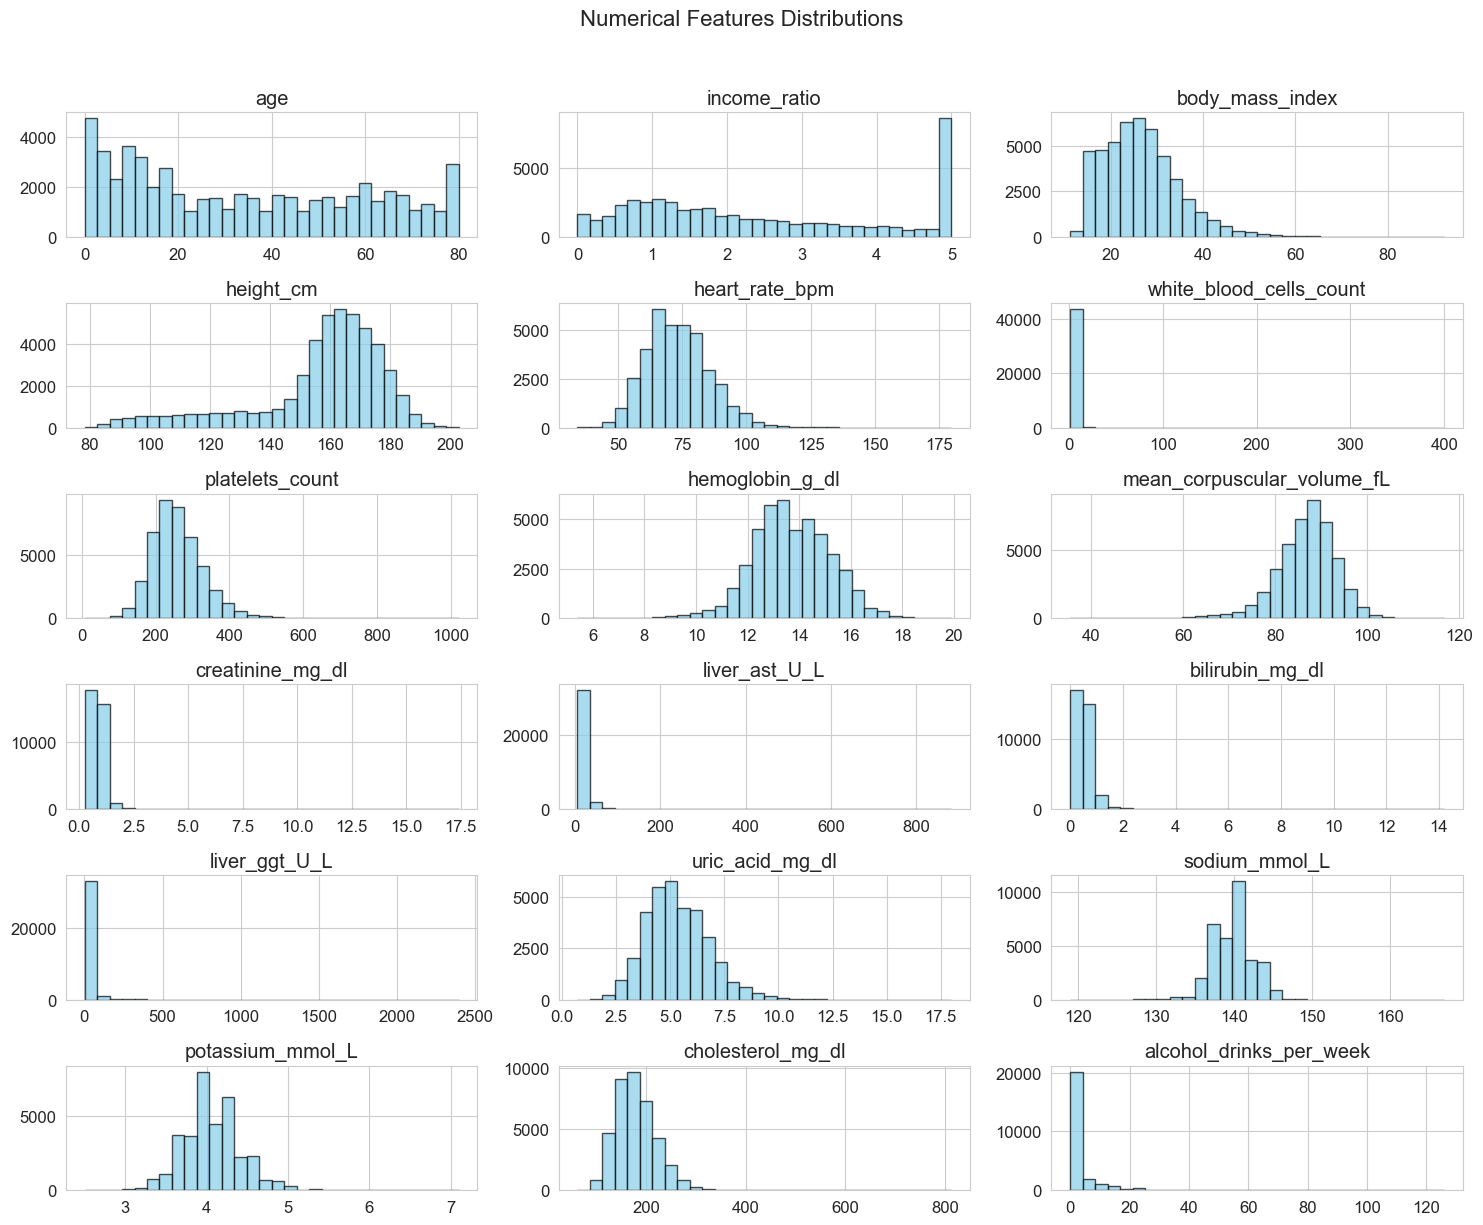

In [ ]:
# =========================================================
# 2. NUMERICAL (CONTINUOUS) FEATURES ANALYSIS
# =========================================================

print("="*80)
print("2. NUMERICAL FEATURES: Descriptive Statistics")
print("="*80)

if len(numerical_cols) > 0:
    print(f"\nAnalyzing {len(numerical_cols)} numerical variables:")
    display(df[numerical_cols].describe().T)
    
    # Visualize all numerical features using pandas hist()
    df[numerical_cols].hist(bins=30, figsize=(15, 12), layout=(6, 3), 
                            color='skyblue', alpha=0.7, edgecolor='black')
    plt.suptitle('Numerical Features Distributions', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No numerical variables found.")


3. CATEGORICAL FEATURES: Distribution Analysis

Analyzing 3 categorical variables:

gender:
  2.0: 29,145 (51.23%)
  1.0: 27,748 (48.77%)
  Missing: 0 (0.00%)


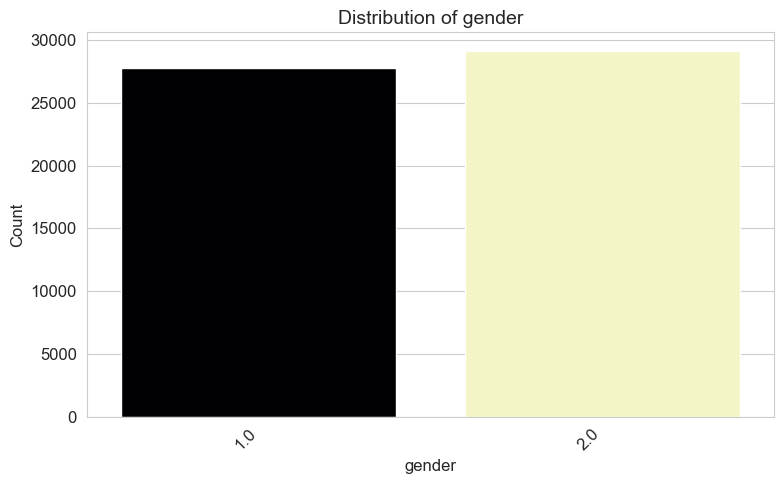


ethnicity:
  3.0: 21,378 (37.58%)
  4.0: 12,206 (21.45%)
  1.0: 8,125 (14.28%)
  2.0: 6,005 (10.55%)
  6.0: 5,603 (9.85%)
  7.0: 3,576 (6.29%)
  Missing: 0 (0.00%)


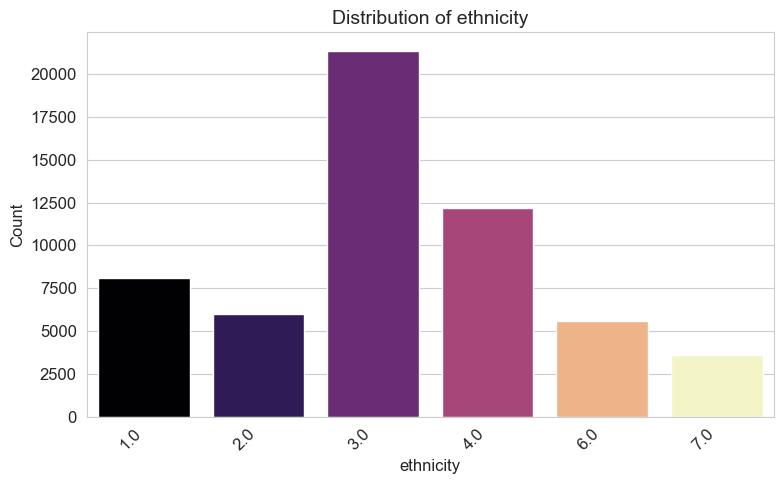


smoking_status:
  nan: 42,401 (74.53%)
  3.0: 8,265 (14.53%)
  1.0: 4,887 (8.59%)
  2.0: 1,340 (2.36%)
  Missing: 42,401 (74.53%)


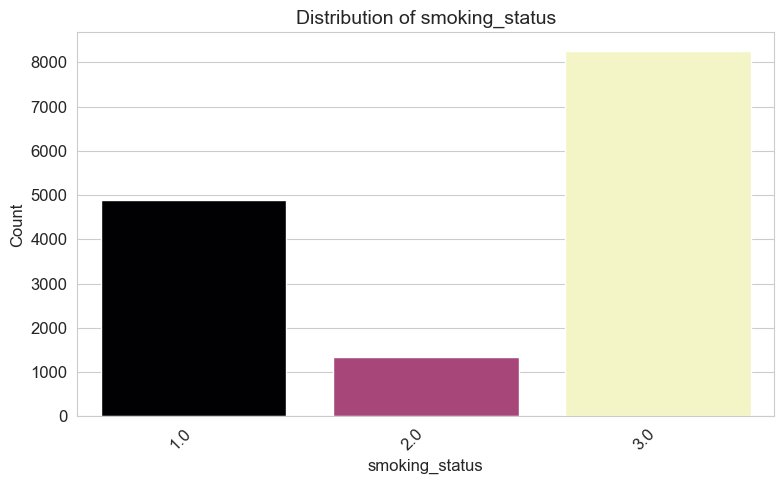

In [ ]:
# =========================================================
# 3. CATEGORICAL FEATURES ANALYSIS
# =========================================================

print("="*80)
print("3. CATEGORICAL FEATURES: Distribution Analysis")
print("="*80)

if len(categorical_cols) > 0:
    print(f"\nAnalyzing {len(categorical_cols)} categorical variables:")
    
    for col in categorical_cols:
        counts = df[col].value_counts(dropna=False)
        pct = df[col].value_counts(normalize=True, dropna=False) * 100
        missing = df[col].isnull().sum()
        
        print(f"\n{col}:")
        for val, count in counts.items():
            print(f"  {val}: {count:,} ({pct[val]:.2f}%)")
        print(f"  Missing: {missing:,} ({missing/len(df)*100:.2f}%)")
        
        # Visualize if reasonable number of categories
        if counts.shape[0] <= 10:
            plt.figure(figsize=(8, 5))
            sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette='magma', legend=False)
            plt.title(f'Distribution of {col}', fontsize=14)
            plt.ylabel('Count')
            plt.xlabel(col)
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
else:
    print("No categorical variables found.")
